In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from pandas.plotting import scatter_matrix
import scipy.stats as stats
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn import neighbors, datasets, tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import string
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing the data
initial_data = pd.read_csv('data/winemag-data_first150k.csv')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   designation  105195 non-null  object 
 4   points       150930 non-null  int64  
 5   price        137235 non-null  float64
 6   province     150925 non-null  object 
 7   region_1     125870 non-null  object 
 8   region_2     60953 non-null   object 
 9   variety      150930 non-null  object 
 10  winery       150930 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


In [5]:
dropped_regions = initial_data.drop(['region_1', 'region_2', 'designation', 'winery'], axis=1)

In [6]:
dropped_regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   150930 non-null  int64  
 1   country      150925 non-null  object 
 2   description  150930 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   variety      150930 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 8.1+ MB


In [7]:
print(dropped_regions.isna().sum())

Unnamed: 0         0
country            5
description        0
points             0
price          13695
province           5
variety            0
dtype: int64


<AxesSubplot:>

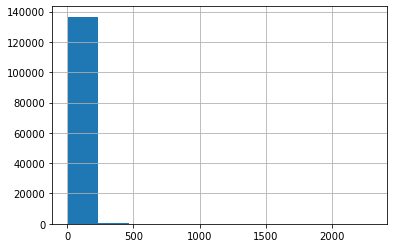

In [8]:
dropped_regions['price'].hist()

In [9]:
dropped_regions['price'].describe()

count    137235.000000
mean         33.131482
std          36.322536
min           4.000000
25%          16.000000
50%          24.000000
75%          40.000000
max        2300.000000
Name: price, dtype: float64

<AxesSubplot:>

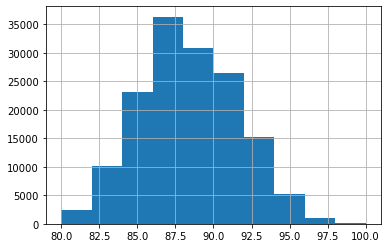

In [10]:
dropped_regions['points'].hist(bins=10)

In [11]:
dropped_regions['points'].describe()

count    150930.000000
mean         87.888418
std           3.222392
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

In [12]:
dropped_regions['country'].describe()

count     150925
unique        48
top           US
freq       62397
Name: country, dtype: object

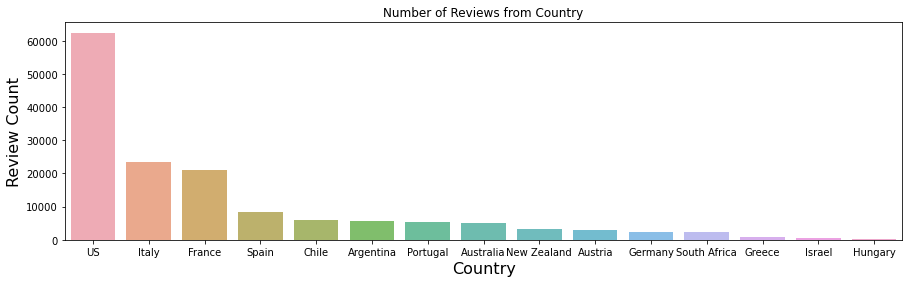

In [13]:
country_count = dropped_regions['country'].value_counts()
country_count = country_count[:15,]
plt.figure(figsize=(15,4))
sns.barplot(country_count.index, country_count.values, alpha=0.8)
plt.title('Number of Reviews from Country')
plt.ylabel('Review Count', fontsize=16)
plt.xlabel('Country', fontsize=16)
plt.show()

In [14]:
dropped_regions.head()

,Unnamed: 0,country,description,points,price,province,variety
0,0,US,"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.",96,235.0,California,Cabernet Sauvignon
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.",96,110.0,Northern Spain,Tinta de Toro
2,2,US,"Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.",96,90.0,California,Sauvignon Blanc
3,3,US,"This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.",96,65.0,Oregon,Pinot Noir
4,4,France,"This is the top wine from La Bégude, named after the highest point in the vineyard at 1200 feet. It has structure, density and considerable acidity that is still calming down. With 18 months in wood, the wine has developing an extra richness and concentration. Produced by the Tari family, formerly of Château Giscours in Margaux, it is a wine made for aging. Drink from 2020.",95,66.0,Provence,Provence red blend


In [15]:
variety_count = dropped_regions['variety'].value_counts()
len(variety_count)


632

In [16]:
#selecting the kinds of grape variety I want to test
new_df = dropped_regions[(dropped_regions['variety'] == 'Chardonnay') | (dropped_regions['variety'] == 'Pinot Noir') | (dropped_regions['variety'] == 'Cabernet Sauvignon') | (dropped_regions['variety'] == 'Bordeaux-style Red Blend') | (dropped_regions['variety'] == 'Sauvignon Blanc') | (dropped_regions['variety'] == 'Syrah') | (dropped_regions['variety'] == 'Riesling') | (dropped_regions['variety'] == 'Merlot') | (dropped_regions['variety'] == 'Zinfandel') | (dropped_regions['variety'] == 'Sangiovese') | (dropped_regions['variety'] == 'Malbec') | (dropped_regions['variety'] == 'Tempranillo') | (dropped_regions['variety'] == 'Nebbiolo') | (dropped_regions['variety'] == 'Shiraz') | (dropped_regions['variety'] == 'Molinara') | (dropped_regions['variety'] == 'Barbera') | (dropped_regions['variety'] == 'Pinot Gris') | (dropped_regions['variety'] == 'Cabernet Franc') | (dropped_regions['variety'] == 'Pinot Grigio') | (dropped_regions['variety'] == 'Viognier') | (dropped_regions['variety'] == 'Grüner Veltliner') | (dropped_regions['variety'] == 'Gewürztraminer') | (dropped_regions['variety'] == 'Chenin Blanc') | (dropped_regions['variety'] == 'Glera') | (dropped_regions['variety'] == 'Albariño') | (dropped_regions['variety'] == 'Pinot Blanc')]
new_df.shape

(99838, 7)

In [17]:
#eliminating duplicate entries
new_df = new_df.drop_duplicates('description', keep='first')

In [18]:
new_df.shape

(64080, 7)

In [19]:
variety_count_2 = new_df['variety'].value_counts()
variety_count_2

Pinot Noir                  9282
Chardonnay                  9159
Cabernet Sauvignon          8270
Bordeaux-style Red Blend    5170
Sauvignon Blanc             4033
Syrah                       3661
Riesling                    3583
Merlot                      3178
Zinfandel                   2408
Sangiovese                  2152
Malbec                      1968
Tempranillo                 1622
Nebbiolo                    1339
Shiraz                      1254
Pinot Gris                   899
Cabernet Franc               883
Viognier                     859
Pinot Grigio                 831
Grüner Veltliner             714
Gewürztraminer               681
Barbera                      635
Chenin Blanc                 457
Albariño                     365
Glera                        342
Pinot Blanc                  335
Name: variety, dtype: int64

In [20]:
# adding a column that says whether the wine is red or white based on the grape variety
kind = []
for wine in new_df['variety']:
    if wine == 'Chardonnay':
        kind.append('White')
    if wine == 'Pinot Noir':
        kind.append('Red')
    if wine == 'Cabernet Sauvignon':
        kind.append('Red')
    if wine == 'Bordeaux-style Red Blend':
        kind.append('Red')
    if wine == 'Sauvignon Blanc':
        kind.append('White')
    if wine == 'Syrah':
        kind.append('Red')
    if wine == 'Riesling':
        kind.append('White')
    if wine == 'Merlot':
        kind.append('Red')
    if wine == 'Zinfandel':
        kind.append('Red')
    if wine == 'Sangiovese':
        kind.append('Red')
    if wine == 'Malbec':
        kind.append('Red')
    if wine == 'Tempranillo':
        kind.append('Red')
    if wine == 'Nebbiolo':
        kind.append('Red')
    if wine == 'Shiraz':
        kind.append('Red')
    if wine == 'Barbera':
        kind.append('Red')
    if wine == 'Pinot Gris':
        kind.append('White')
    if wine == 'Cabernet Franc':
        kind.append('Red')
    if wine == 'Pinot Grigio':
        kind.append('White')
    if wine == 'Viognier':
        kind.append('White')
    if wine == 'Grüner Veltliner':
        kind.append('White')
    if wine == 'Gewürztraminer':
        kind.append('White')
    if wine == 'Chenin Blanc':
        kind.append('White')
    if wine == 'Glera':
        kind.append('White')
    if wine == 'Albariño':
        kind.append('White')
    if wine == 'Pinot Blanc':
        kind.append('White')
    

new_df['Red_White'] = kind


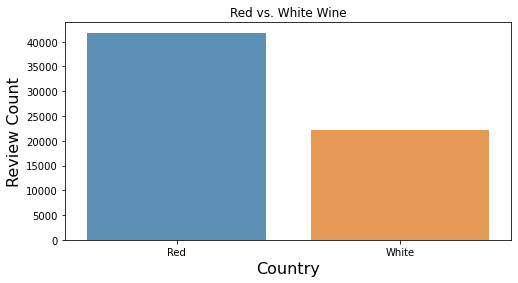

In [21]:
red_white_count = new_df['Red_White'].value_counts()


plt.figure(figsize=(8,4))
sns.barplot(red_white_count.index, red_white_count.values, alpha=0.8)
plt.title('Red vs. White Wine')
plt.ylabel('Review Count', fontsize=16)
plt.xlabel('Country', fontsize=16)
plt.show()

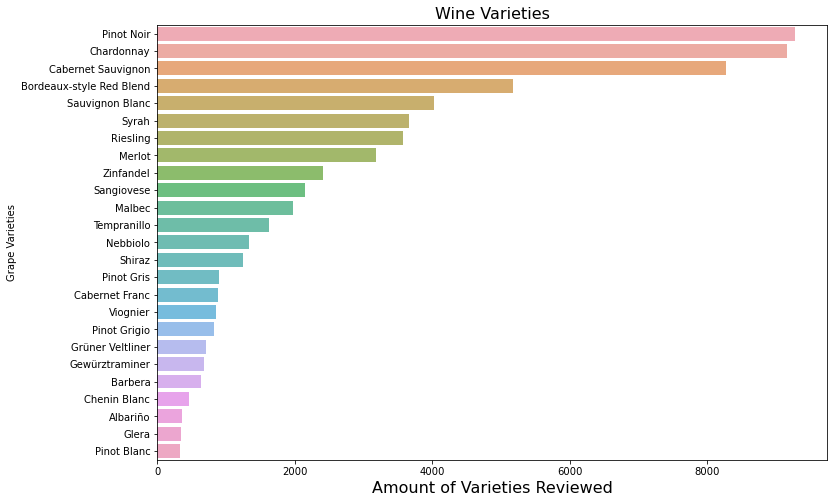

In [22]:
red_white_count = new_df['variety'].value_counts()


plt.figure(figsize=(12,8))
sns.barplot(y = red_white_count.index, x = red_white_count.values,  alpha=0.8)
plt.title('Wine Varieties', fontsize=16)
plt.ylabel('Grape Varieties', fontsize=10)
plt.xlabel('Amount of Varieties Reviewed', fontsize=16)
plt.show()

In [23]:
new_df.head()

,Unnamed: 0,country,description,points,price,province,variety,Red_White
0,0,US,"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.",96,235.0,California,Cabernet Sauvignon,Red
2,2,US,"Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.",96,90.0,California,Sauvignon Blanc,White
3,3,US,"This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.",96,65.0,Oregon,Pinot Noir,Red
8,8,US,"This re-named vineyard was formerly bottled as deLancellotti. You'll find striking minerality underscoring chunky black fruits. Accents of citrus and graphite comingle, with exceptional midpalate concentration. This is a wine to cellar, though it is already quite enjoyable. Drink now through 2030.",95,65.0,Oregon,Pinot Noir,Red
9,9,US,"The producer sources from two blocks of the vineyard for this wine—one at a high elevation, which contributes bright acidity. Crunchy cranberry, pomegranate and orange peel flavors surround silky, succulent layers of texture that present as fleshy fruit. That delicately lush flavor has considerable length.",95,60.0,California,Pinot Noir,Red


In [24]:
#begin NLP process by making all lowercase
# for i, words in enumerate(new_df['description']):
#     new_df['description'][i] = words.lower()
new_df['description'] = [words.lower() for words in new_df['description']]


In [25]:
#tokenize
# for i,words in enumerate(new_df['description']):
#     new_df['description'][i] = word_tokenize(words)
    
new_df['description'] = [word_tokenize(words) for words in new_df['description']]  

In [26]:
#strip punctuation 
pt = string.punctuation
# for i,words in enumerate(new_df['description']):
#     new_df['description'][i] = [word for word in words if not word in pt]
    
new_df['description'] = [[word for word in words if not word in pt] for words in new_df['description']]

In [27]:
#removing stop words

extras = ['red', 'white', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Syrah', 'Sangiovese',
       'Riesling', 'Nebbiolo', 'Pinot Gris', 'Glera', 'Viognier',
       'Pinot Grigio', 'Cabernet Franc', 'Zinfandel', 'Barbera',
       'Albariño', 'Bordeaux-style Red Blend', 'Gewürztraminer', 'Merlot',
       'Grüner Veltliner', 'Pinot Blanc', 'Shiraz', 'Chenin Blanc']
stop = set(stopwords.words('english'))
stop.update(extras)

new_df['description'] = [[token for token in words if token not in stop] for words in new_df['description']]

# for i,words in enumerate(new_df['description']):
#     new_df['description'][i] = [token for token in words if token not in stop]

In [28]:
stemmer = SnowballStemmer('english')
docs1 = []
for i,word in enumerate(new_df['description']):
    docs1.append([stemmer.stem(token) for token in word])
docs1

[['tremend',
  '100',
  'variet',
  'wine',
  'hail',
  'oakvill',
  'age',
  'three',
  'year',
  'oak',
  'juici',
  'red-cherri',
  'fruit',
  'compel',
  'hint',
  'caramel',
  'greet',
  'palat',
  'frame',
  'eleg',
  'fine',
  'tannin',
  'subtl',
  'minti',
  'tone',
  'background',
  'balanc',
  'reward',
  'start',
  'finish',
  'year',
  'ahead',
  'develop',
  'nuanc',
  'enjoy',
  '2022–2030'],
 ['mac',
  'watson',
  'honor',
  'memori',
  'wine',
  'made',
  'mother',
  'tremend',
  'delici',
  'balanc',
  'complex',
  'botrytis',
  'dark',
  'gold',
  'color',
  'layer',
  'toast',
  'hazelnut',
  'pear',
  'compot',
  'orang',
  'peel',
  'flavor',
  'revel',
  'succul',
  '122',
  'g/l',
  'residu',
  'sugar'],
 ['spent',
  '20',
  'month',
  '30',
  'new',
  'french',
  'oak',
  'incorpor',
  'fruit',
  'ponzi',
  "'s",
  'aurora',
  'abetina',
  'madrona',
  'vineyard',
  'among',
  'other',
  'aromat',
  'dens',
  'toasti',
  'deft',
  'blend',
  'aroma',
  'flavor'

In [29]:
# lemmatizer = WordNetLemmatizer()
# tokenization = word_tokenize(text)

# for i,words in enumerate(new_df['description']):
#     new_df['description'][i] = [lemmatizer.lemmatize(token) for token in doc]

# new_df['description'] = [[lemmatizer.lemmatize(token) for token in doc] 

In [30]:
# creating the vocabulary and initializing the BoW matrix
vocabulary = set()
for words in new_df['description']:
    for token in words:
        vocabulary.add(token)

vocabulary_lookup = {word: i for i, word in enumerate(vocabulary)}
matrix = np.zeros((len(new_df['description']), len(vocabulary)))


In [31]:
# creating the bag of words
for word_id, words in enumerate(new_df['description']):
    for token in words:
        word_id_2 = vocabulary_lookup[token]
        matrix[word_id][word_id_2] += 1

In [53]:
# visualizing the bag of words
columns = sorted(vocabulary_lookup, key=lambda key: vocabulary_lookup[key])
df = pd.DataFrame(matrix.astype('int'), columns=columns); df


KeyboardInterrupt: 

In [52]:
#compute tfidf
tf = df / df.sum(axis='').values.reshape(-1, 1)

idf = np.log(matrix.shape[0] / np.sum(matrix > 0, axis=0))

tfidf = tf * idf; tfidf.round(2)

ValueError: No axis named 4 for object type DataFrame

In [38]:
new_df.head(3)

,Unnamed: 0,country,description,points,price,province,variety,Red_White
0,0,US,"[tremendous, 100, varietal, wine, hails, oakville, aged, three, years, oak, juicy, red-cherry, fruit, compelling, hint, caramel, greet, palate, framed, elegant, fine, tannins, subtle, minty, tone, background, balanced, rewarding, start, finish, years, ahead, develop, nuance, enjoy, 2022–2030]",96,235.0,California,Cabernet Sauvignon,Red
2,2,US,"[mac, watson, honors, memory, wine, made, mother, tremendously, delicious, balanced, complex, botrytised, dark, gold, color, layers, toasted, hazelnut, pear, compote, orange, peel, flavors, reveling, succulence, 122, g/l, residual, sugar]",96,90.0,California,Sauvignon Blanc,White
3,3,US,"[spent, 20, months, 30, new, french, oak, incorporates, fruit, ponzi, 's, aurora, abetina, madrona, vineyards, among, others, aromatic, dense, toasty, deftly, blends, aromas, flavors, toast, cigar, box, blackberry, black, cherry, coffee, graphite, tannins, polished, fine, sheen, frame, finish, loaded, dark, chocolate, espresso, drink, 2032]",96,65.0,Oregon,Pinot Noir,Red


In [54]:
vectorizer = TfidfVectorizer(max_features=1500)

In [55]:
#putting wine descriptions into a list and applying tfidfvectorizer
# desc_text = list(new_df.description)
X = new_df['description']

In [56]:
#putting wine varieties into a list and applying tfidfvectorizer
variety_text = list(new_df.variety)
y = new_df['variety']

In [57]:

# red_white_text = list(new_df.Red_White)
# z = vectorizer.fit_transform(red_white_text)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48060,), (16020,), (48060,), (16020,))

In [63]:
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

ValueError: setting an array element with a sequence.